**NOTE:** This notebook uses the cropped images of vehicles extracted from the original aerial imagery by running the Image Pre-Processing notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math

from collections import Counter
from keras import backend as K
from keras import models, layers, optimizers, losses, applications, callbacks, metrics
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


Define the network using MobileNet as base model.

In [2]:
class MNet(models.Sequential):
    """
        Using pre-trained MobileNet without head
    """
    def __init__(self, outputs=37, output_layer='sigmoid', **kwargs):
        super(MNet, self).__init__()

        sizes = [(128,128,3), (4,4,1024), 1024, outputs]

        # Load the pre-trained base model
        base = applications.MobileNet(
            weights='imagenet',
            include_top=False,
            input_shape=sizes[0])

        self.add(base)
        self.add(layers.Flatten())
        self.add(layers.Dense(sizes[-2], activation='relu'))
        self.add(layers.Dense(sizes[-1], activation=output_layer))

Define image data generators for training, validation and test sets.

In [3]:
source_dir = './dataset_v2/train/classes/'
category = ''

generator_args = {
    'validation_split':0.2,
#     'rotation_range':45,
#     'width_shift_range':0.2,
#     'height_shift_range':0.2,
#     'horizontal_flip':True,
#     'vertical_flip':True,
#     'fill_mode':'constant',
#     'cval':255    
}
generator = ImageDataGenerator(**generator_args)
        
flow_args = {
    'target_size':(128, 128),
    'batch_size':32,
    'directory': f'{source_dir}{category}',
    # 'save_to_dir':'../dataset_v2/train/saved'
}

train_gen = generator.flow_from_directory(subset='training', **flow_args)
valid_gen = generator.flow_from_directory(subset='validation', **flow_args)
test_gen = ImageDataGenerator().flow_from_directory(
    directory='./dataset_v2/test/', 
    shuffle=False, 
    target_size=(128, 128), 
    batch_size=32
)

Found 30330 images belonging to 37 classes.
Found 7565 images belonging to 37 classes.
Found 11879 images belonging to 1 classes.


Define weighted cross-entropy loss function.

In [4]:
def get_class_weight(generator):
    Nm = np.array(sorted(Counter(generator.classes).items()))[:,1]
    w0 = np.maximum(Nm.astype(np.float)/generator.samples, 0.1)
    return (1 - w0) / w0

w = get_class_weight(train_gen)
_EPSILON = K.epsilon()

def weighted_crossentropy(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(K.constant(w) * y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

Set the model and training parameters and fit to the training data.

- The model arguments allows for specifying the number of outputs and output layer. Doing so, the defined model can be used for mutually exclusive features as an extension of the baseline solution.
- The compile arguments sets the optimizer and loss function, changing between binary and weighted cross-entropy.
- The fit generator arguments sets the data generators as well as the number of training epochs and callbacks to be used during training. The callbacks include an early stopping criteria and a checkpoint saver.

In [5]:
model_args = {
    # 'outputs':len(train_gen.class_indices),
    # 'output_layer':'softmax'
}

compile_args = {
    'optimizer':optimizers.SGD(
        lr=0.01, 
        momentum=0.9),
    'loss':losses.binary_crossentropy,
#     'loss':weighted_crossentropy,
    'metrics':['acc']
}

fit_gen_args = {
    'generator':train_gen,
    'validation_data':valid_gen,
    'steps_per_epoch':len(train_gen),
    'validation_steps':len(valid_gen),
    'epochs':50,
#     'class_weight':dict(enumerate(w)),
#     'callbacks':[
#         callbacks.EarlyStopping(
#             monitor='val_loss', 
#             min_delta=1e-4, 
#             patience=15, 
#             restore_best_weights=True),
#         callbacks.ModelCheckpoint(
#             filepath='../models/divided/checkpoint.hdf5', 
#             monitor='val_acc', 
#             save_weights_only=True,
#             save_best_only=True)
#     ],
}

# model_path = '../models/mnet50aug-wce-2.h5'
model = MNet(**model_args)    
model.summary()
model.compile(**compile_args)
# model.load_weights(model_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dense_2 (Dense)              (None, 37)                37925     
Total params: 20,045,029
Trainable params: 20,023,141
Non-trainable params: 21,888
_________________________________________________________________


In [6]:
history = model.fit_generator(**fit_gen_args)
# model.save_weights(model_path)

Epoch 1/50
948/948 [==============================] - 54s 57ms/step - loss: 0.0961 - acc: 0.9690 - val_loss: 0.0814 - val_acc: 0.9727
Epoch 2/50
948/948 [==============================] - 50s 53ms/step - loss: 0.0783 - acc: 0.9718 - val_loss: 0.0787 - val_acc: 0.9723
Epoch 3/50
948/948 [==============================] - 50s 52ms/step - loss: 0.0745 - acc: 0.9719 - val_loss: 0.0781 - val_acc: 0.9720
Epoch 4/50
948/948 [==============================] - 49s 52ms/step - loss: 0.0717 - acc: 0.9718 - val_loss: 0.0776 - val_acc: 0.9716
Epoch 5/50
948/948 [==============================] - 50s 52ms/step - loss: 0.0699 - acc: 0.9719 - val_loss: 0.0769 - val_acc: 0.9723
Epoch 6/50
948/948 [==============================] - 49s 52ms/step - loss: 0.0684 - acc: 0.9718 - val_loss: 0.0766 - val_acc: 0.9717
Epoch 7/50
948/948 [==============================] - 50s 52ms/step - loss: 0.0671 - acc: 0.9717 - val_loss: 0.0765 - val_acc: 0.9722ETA: 2s - loss: 0.06 - ETA: 0s - loss: 0.0671 - ac
Epoch 8/50
9

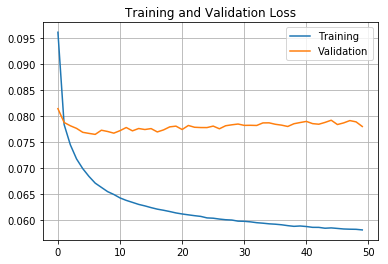

In [7]:
plt.figure()
plt.title('Training and Validation Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='best')
plt.grid()
plt.savefig('./figures/mnet50-loss.eps')
plt.show()

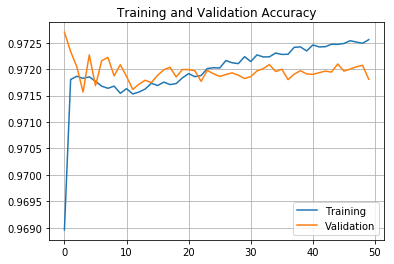

In [8]:
plt.figure()
plt.title('Training and Validation Accuracy')
plt.plot(history.history['acc'], label='Training')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend(loc='best')
plt.grid()
plt.savefig('./figures/mnet50-acc.eps')
plt.show()

Helper functions for creating a submission in accordance with the competition template.

In [9]:
def get_pred_index(dataset='test'):
    df = pd.read_csv(f'./dataset_v2/{dataset}.csv')
    df = df.groupby(['image_id', 'tag_id']).first()
    df = df.reset_index('image_id', drop=True)
    return df.index

def get_pred_columns():
    df = pd.read_csv('./dataset_v2/train.csv')
    df = df.drop(df.columns[:10], axis=1)
    for category in df.columns[df.dtypes == object]:
        df[category] = df[category].astype('category')
    df = pd.get_dummies(df, prefix='', prefix_sep='')
    return sorted(df.columns)

def create_answers_by_columns(proba, cols):
    pred = pd.DataFrame(proba, index=get_pred_index(), columns=cols)

    answers = pd.read_csv('../dataset_v2/answer_template.csv')
    for col in pred.columns:
        answers[col] = pred[col].sort_values(ascending=False).index

    for col in set(answers.columns) - set(pred.columns):
        answers[col] = answers[pred.columns[0]]

    answers.to_csv('../dataset_v2/answer.csv', index=False)

def create_answers(proba):
    predictions = pd.DataFrame(proba,
                        index=get_pred_index(), 
                        columns=get_pred_columns())

    answers = pd.read_csv('./dataset_v2/answer_template.csv')
    for column in answers.columns:
        answers[column] = predictions[column].sort_values(ascending=False).index

    answers.to_csv('./dataset_v2/answer.csv', index=False)

Use the trained model to predict answers for the test set.

In [10]:
proba = model.predict_generator(test_gen, steps=len(test_gen))
create_answers(proba)

# In case of predicting a subset of features
# cols = os.listdir(f'{source_dir}{category}')

# Some additional string manipulation may be required to 
# conform with the column names used in template
# cols = [x.replace('_', ' ') for x in cols]

# create_answers_by_columns(proba, cols)

This notebook provides a minimal extraction of the original source code to reproduce the results. 

Refer to the source directory for the full listing, including
- AP and MAP scoring functions for validation data
- A model based on ResNet50
- Functions for training multiple classifiers
- Plotting tools

and more.